### Installing Dependencies

In [1]:
!pip install mtcnn


In [1]:
pip install -q -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import os
import random
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
from mtcnn.mtcnn import MTCNN
import uuid
import tensorflow_addons as tfa
from tensorflow.keras.metrics import Precision,Recall

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf
import keras

In [4]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
P_path=os.path.join('data','positive')
N_path=os.path.join('data','negitive')
A_path=os.path.join('data','anchor')

In [22]:
P_path=os.path.join('data','positive')
N_path=os.path.join('data','negitive')
A_path=os.path.join('data','anchor')
os.makedirs(P_path)
os.makedirs(N_path)
os.makedirs(A_path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [7]:
!tar -xf lfw.tgz

In [8]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        OLD_PATH=os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(N_path,file)
        os.replace(OLD_PATH,NEW_PATH)

In [6]:
detector=MTCNN()
def exface(image):
    resize=(250,250)
    faces=detector.detect_faces(image)
    x,y,w,h=faces[0]['box']
    x1=x+w
    y1=y+h
    face_boundary=image[y:y1,x:x1]
    ex_face=cv2.resize(face_boundary,resize)
    return ex_face

In [ ]:

cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    
    frame=exface(frame)
    cv2.imshow("Image Collection",frame)
    if cv2.waitKey(1) & 0XFF==ord('a'):
        imgname=os.path.join(A_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    if cv2.waitKey(1) & 0XFF==ord('p'):
        imgname=os.path.join(P_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [7]:

    negitive_dir="C:/Users/hp/data/neg"
    pp="C:/Users/hp/data/fac2"
    for file in os.listdir(negitive_dir):
        try:
            
            pic_dir=os.path.join(negitive_dir,file)
            pic=cv2.imread(pic_dir)
            face_pic=exface(pic)
            imgname=os.path.join(pp,'{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname,face_pic)
            os.remove(pic_dir)
        except Exception:
            continue

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/hp/data/neg'

In [16]:
anchor = tf.data.Dataset.list_files(A_path+ '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(P_path+ '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(N_path+ '\*.jpg').take(300)

In [17]:
def preprocess(path):
    byte_img=tf.io.read_file(path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(105,105))
    img=img/255.0
    return img   

In [18]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negitives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negitives)

In [19]:
samples=data.as_numpy_iterator()
example=samples.next()

In [20]:
def prep(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label) 

In [21]:
result=prep(*example)
result[0]

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.12362056, 0.13146369, 0.11969899],
        [0.1093304 , 0.11717354, 0.10540883],
        [0.09747899, 0.10532213, 0.09000934],
        ...,
        [0.1254902 , 0.10588235, 0.09411765],
        [0.1254902 , 0.10588235, 0.09411765],
        [0.12670402, 0.10709617, 0.09533147]],

       [[0.10540883, 0.12473656, 0.10989062],
        [0.10476191, 0.11318528, 0.10192077],
        [0.09745231, 0.10575563, 0.09383754],
        ...,
        [0.12346938, 0.10616247, 0.09396425],
        [0.12156863, 0.10616247, 0.09383754],
        [0.1254902 , 0.11008403, 0.09775911]],

       [[0.10036237, 0.11604864, 0.11212707],
        [0.09361745, 0.10945712, 0.10507537],
        [0.0917656 , 0.10748744, 0.09568717],
        ...,
        [0.13436039, 0.11904762, 0.10121381],
        [0.12524343, 0.11347873, 0.09387088],
        [0.12726425, 0.11549953, 0.09589169]],

       ...,

       [[0.28748834, 0.27180207, 0.2286648 ],
        [0.29

In [22]:
data=data.map(prep)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [23]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [24]:
samp=data.as_numpy_iterator()
examp=samp.next()
examp

(array([[[0.15284559, 0.11755147, 0.09794363],
         [0.15872349, 0.12342938, 0.10382152],
         [0.17487217, 0.13957806, 0.11997021],
         ...,
         [0.18133698, 0.14959092, 0.11252277],
         [0.17545018, 0.14015606, 0.10486194],
         [0.1659197 , 0.13062559, 0.09533147]],
 
        [[0.16713351, 0.13239963, 0.11251167],
         [0.17282914, 0.13809524, 0.11820728],
         [0.16685341, 0.1321195 , 0.11223156],
         ...,
         [0.194211  , 0.15863678, 0.12334266],
         [0.18123248, 0.14565825, 0.11036414],
         [0.1767507 , 0.13753502, 0.1022409 ]],
 
        [[0.15479746, 0.13089457, 0.10736516],
         [0.1636788 , 0.1397759 , 0.1162465 ],
         [0.15701169, 0.1331088 , 0.10957938],
         ...,
         [0.19409986, 0.15488417, 0.11959006],
         [0.19557825, 0.15636256, 0.12106843],
         [0.19355743, 0.15434174, 0.11904762]],
 
        ...,
 
        [[0.31213817, 0.26647985, 0.23333327],
         [0.32717082, 0.2815125 , 0.24836

In [ ]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [200]:
for file_name in os.listdir(os.path.join(P_path)):
    img_path = os.path.join(P_path, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(P_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [201]:
for file_name in os.listdir(os.path.join(A_path)):
    img_path = os.path.join(A_path, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(A_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [25]:
train_data=data.take(round(len(data)*0.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [26]:
test_data=data.skip(round(len(data)*.7))
test_data=test_data.take(round(len(data)*.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

In [27]:
def m_embedding():
    inp=Input(shape=(105,105,3),name='Inupt_name')
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [28]:
embedding=m_embedding()

In [29]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inupt_name (InputLayer)     [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 18, 18, 128)       26

In [30]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
        
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [31]:
l1=L1Dist()

In [32]:
def siamese_model():
    input_image=Input(name='input_img',shape=(105,105,3))
    validation_image=Input(name='validation_img',shape=(105,105,3))
    siamese_layer=L1Dist()
    siamese_layer._name='distance'
    distances=siamese_layer(embedding(input_image),embedding(validation_image))
    
    #last sigmoid layer
    
    last=Dense(1,activation='sigmoid')(distances)
    
    #last sigmoid layer
    
    return Model(inputs=[input_image,validation_image],outputs=last,name='Siamese_Network')

In [33]:
model=siamese_model()

In [34]:
model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

In [35]:
Tloss=tf.losses.BinaryCrossentropy()
opt=tf.keras.optimizers.Adam(1e-4)

In [36]:
checkpoint_dir="C:/Users/hp/training_checkpoints"
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,model=model)

In [37]:
test_batch=train_data.as_numpy_iterator()
batch=test_batch.next()

In [38]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X=batch[:2]
        y=batch[2]
        yhat=model(X,training=True)
        loss=Tloss(y,yhat)
    print(loss)
        
    #calc gradient
    grad=tape.gradient(loss,model.trainable_variables)

    #apply the updated weights

    opt.apply_gradients(zip(grad,model.trainable_variables))
    return loss

In [39]:
def train(data,Epochs):
    for epoch in range(1,Epochs+1):
        print("\n Epoch{}/{}".format(epoch,Epochs))
        progbar=tf.keras.utils.Progbar(len(data))
        
        
        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [40]:
Epochs=50
train(train_data,Epochs)


 Epoch1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 41s 425ms/step

 Epoch2/50
27/27 [==============================] - 10s 369ms/step

 Epoch3/50
27/27 [==============================] - 10s 374ms/step

 Epoch4/50
27/27 [==============================] - 10s 379ms/step

 Epoch5/50
27/27 [==============================] - 10s 381ms/step

 Epoch6/50
27/27 [==============================] - 10s 386ms/step

 Epoch7/50
27/27 [==============================] - 10s 389ms/step

 Epoch8/50
27/27 [==============================] - 10s 390ms/step

 Epoch9/50
27/27 [==============================] - 10s 386ms/step

 Epoch10/50
27/27 [==============================] - 10s 389ms/step

 Epoch11/50
27/27 [==============================] - 10s 399ms/step

 Epoch12/50
27/27 [==============================] - 10s 390ms/step

 Epoch13/50
27/27 [=======

In [41]:
test_input,test_val,y_true=test_data.as_numpy_iterator().next()

In [42]:
test_var=test_data.as_numpy_iterator().next

In [43]:
test_var

<bound method _NumpyIterator.next of <tensorflow.python.data.ops.dataset_ops._NumpyIterator object at 0x0000020A2D37E590>>

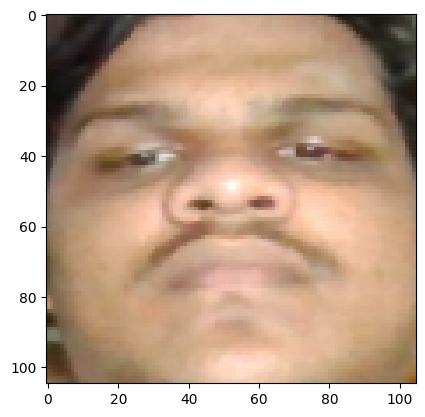

In [44]:
plt.imshow(test_input[3])

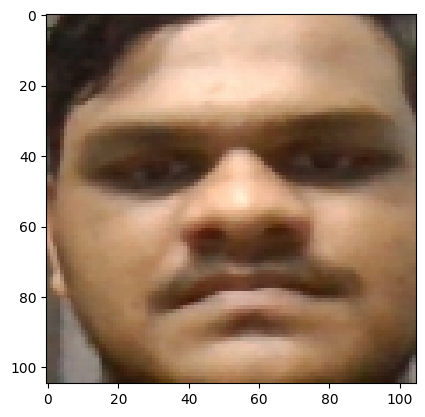

In [45]:
plt.imshow(test_val[3])

In [46]:
y_true[3]

1.0

In [47]:
predictions=model.predict([test_input,test_val])
print(predictions)

1/1 [==============================] - 1s 978ms/step
[[1.0000000e+00]
 [8.7162526e-08]
 [9.9999988e-01]
 [9.9997330e-01]
 [8.5233535e-13]
 [9.9999976e-01]
 [1.0291364e-09]
 [1.6741782e-05]
 [1.1089454e-06]
 [7.7354292e-05]
 [1.4108687e-08]
 [1.7922007e-08]
 [1.2026140e-12]
 [2.7169993e-13]
 [4.4108190e-05]
 [2.2997089e-08]]


In [48]:
[1 if prediction>0.5 else 0 for prediction in predictions]

[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [49]:
y_true

array([1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [50]:
m=Recall()
m.update_state(y_true,predictions)

m.result().numpy()

1.0

In [51]:
m=Precision()
m.update_state(y_true,predictions)
m.result().numpy()

1.0

In [52]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 116ms/step
1.0 1.0


In [53]:
model.save('face_Weight_Final.h5')
L1Dist

__main__.L1Dist

In [56]:
input_dir="C:/Users/hp/application_data/input_image"
for file in os.listdir(input_dir):
    pic_dir=os.path.join(input_dir,file)
    pic=cv2.imread(pic_dir)
    face_pic=exface(pic)
    cv2.imwrite('C:/Users/hp/application_data/input_image/input_image.jpg',face_pic)
    os.remove(pic_dir)

1/1 [==============================] - 0s 215ms/step


In [57]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
ver_dir="C:/Users/hp/application_data/verification_images"
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame=exface(frame)
    cv2.imshow("Verification Image Collection",frame)
    if cv2.waitKey(1) & 0XFF==ord('c'):
        imgname=os.path.join(ver_dir,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    

In [58]:
results,verified=verify(model,0.5,0.5)
print(results)

1/1 [==============================] - 0s 78ms/step
[array([[0.23369981]], dtype=float32), array([[0.00133835]], dtype=float32), array([[0.00071683]], dtype=float32), array([[0.00030025]], dtype=float32), array([[4.280143e-06]], dtype=float32), array([[0.00030782]], dtype=float32), array([[1.8651888e-05]], dtype=float32), array([[0.00019786]], dtype=float32), array([[0.00097682]], dtype=float32), array([[0.00032189]], dtype=float32), array([[0.00046001]], dtype=float32), array([[0.00223969]], dtype=float32), array([[1.6890814e-05]], dtype=float32), array([[0.00804195]], dtype=float32), array([[0.00386726]], dtype=float32), array([[3.3724432e-06]], dtype=float32), array([[0.7869946]], dtype=float32), array([[0.00152926]], dtype=float32), array([[0.98736054]], dtype=float32), array([[0.00183633]], dtype=float32), array([[0.0001394]], dtype=float32), array([[0.9836624]], dtype=float32), array([[0.00063294]], dtype=float32), array([[2.7746226e-05]], dtype=float32), array([[8.03513e-05]], d

In [59]:
li=[1 if prediction>0.5 else 0 for prediction in results]
print(li.count(1))

4


In [61]:
inpu="C:/Users/hp/Testing/1.jpg"
ver="C:/Users/hp/Testing/2.jpg"
input_img = preprocess(inpu)
validation_img = preprocess(ver)
result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
print(result)

1/1 [==============================] - 0s 51ms/step
[[0.89331496]]
